In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, recall_score, accuracy_score, precision_score, confusion_matrix, classification_report, roc_curve, auc
import pickle

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (11.0, 8.0)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Importing Data
df = pd.read_csv('transaction_dataset.csv')
X = df.drop(columns=['Address', 'FLAG'])
y = df['FLAG']
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
df

,Unnamed: 0,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9836,9836,2175,0xff481ca14e6c16b79fc8ab299b4d2387ec8ecdd2,1,12635.10,631.39,58748.48,4,13,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,2.0,,GSENetwork
9837,9837,2176,0xff718805bb9199ebf024ab6acd333e603ad77c85,1,0.00,0.00,0.00,0,0,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,1.0,,Blockwell say NOTSAFU
9838,9838,2177,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,1,2499.44,2189.29,261601.88,67,43,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,5.0,,Free BOB Tokens - BobsRepair.com
9839,9839,2178,0xffde23396d57e10abf58bd929bb1e856c7718218,1,0.00,0.00,0.00,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
columns = ['Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)',
       'Unique Received From Addresses', 'min value received',
       'max value received ', 'avg val received', 'min val sent',
       'avg val sent', 'total transactions (including tnx to create contract',
       'total ether received', 'total ether balance']

scaler = MinMaxScaler()

# Coerce all features to numeric (non-numeric -> NaN) and fill NaNs to avoid conversion errors
for df_ in [X_train_full, X_test]:
    for c in df_.columns:
        df_[c] = pd.to_numeric(df_[c], errors='coerce')
X_train_full = X_train_full.fillna(0)
X_test = X_test.fillna(0)

# Apply safe log transform only to columns that exist
cols_to_log = [c for c in columns if c in X_train_full.columns]
for c in cols_to_log:
    X_train_full[c] = np.where(X_train_full[c] > 0, np.log(X_train_full[c]), 0)
    X_test[c] = np.where(X_test[c] > 0, np.log(X_test[c]), 0)

# Scaling and keep as DataFrame to preserve column names
X_train_full = pd.DataFrame(scaler.fit_transform(X_train_full), columns=X_train_full.columns, index=X_train_full.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Save feature names for later plotting
feature_names = X_train_full.columns.tolist()

# Validate scaling
print(f"NaN values in training data: {np.isnan(X_train_full.values).sum()}")
print(f"NaN values in test data: {np.isnan(X_test.values).sum()}")

NaN values in training data: 0
NaN values in test data: 0


In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import time

logreg = LogisticRegression(max_iter=1000)
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

clf = GridSearchCV(logreg,
                   param_grid=parameters,
                   scoring='f1',
                   cv=10,
                   n_jobs=-1,  # Use all processors
                   verbose=1)

start_time = time.time()
clf.fit(X_train_full, y_train_full)
elapsed_time = time.time() - start_time
print(f"Training completed in {elapsed_time:.2f} seconds")

Fitting 10 folds for each of 42 candidates, totalling 420 fits
Training completed in 4.17 seconds


In [13]:
print("="*50)
print("GRID SEARCH RESULTS")
print("="*50)
print("Tuned Hyperparameters:", clf.best_params_)
print("Train F1 Score:", f"{clf.best_score_:.4f}")
best_y_pr = clf.predict(X_test)
print('Test F1 Score:', f"{f1_score(y_test, best_y_pr):.4f}")

GRID SEARCH RESULTS
Tuned Hyperparameters: {'C': np.float64(0.01), 'penalty': 'l1', 'solver': 'liblinear'}
Train F1 Score: 1.0000
Test F1 Score: 1.0000


In [14]:
logreg = LogisticRegression(C=1000, penalty="l1", solver='liblinear', max_iter=1000)
logreg.fit(X_train_full, y_train_full)
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

print("="*50)
print("MODEL EVALUATION METRICS")
print("="*50)
print(f"F1 Score:       {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC Score:  {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Recall Score:   {recall_score(y_test, y_pred):.4f}")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision Score:{precision_score(y_test, y_pred):.4f}")
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))

MODEL EVALUATION METRICS
F1 Score:       1.0000
ROC-AUC Score:  1.0000
Recall Score:   1.0000
Accuracy Score: 1.0000
Precision Score:1.0000

CLASSIFICATION REPORT
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00      2299
       Fraud       1.00      1.00      1.00       654

    accuracy                           1.00      2953
   macro avg       1.00      1.00      1.00      2953
weighted avg       1.00      1.00      1.00      2953



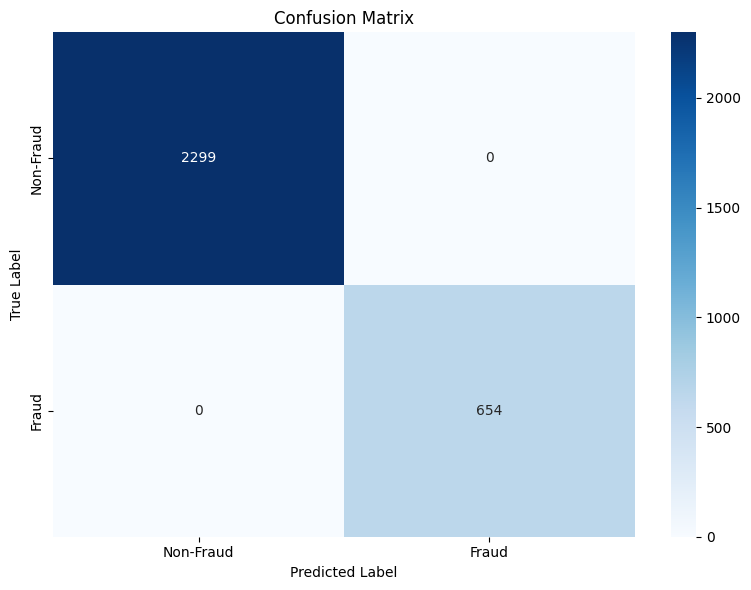

In [15]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
ax.set_title('Confusion Matrix')
plt.tight_layout()
plt.show()

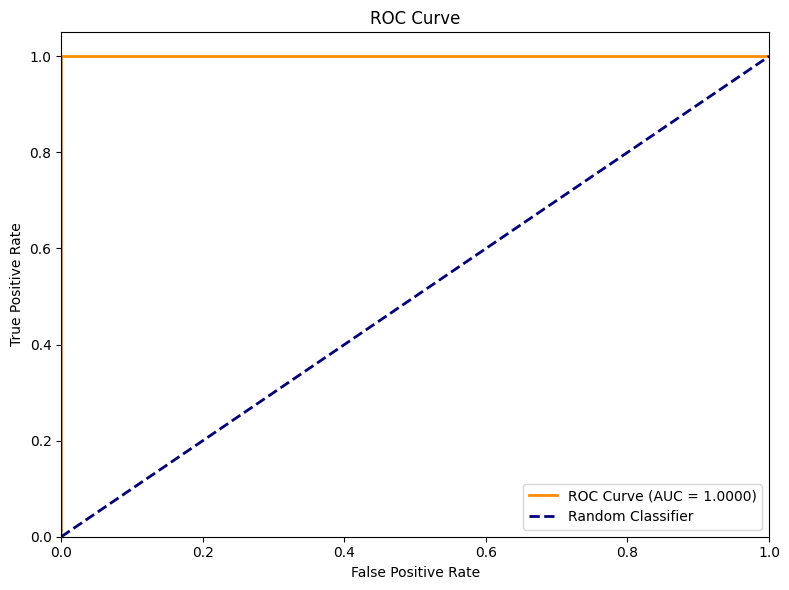

In [16]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

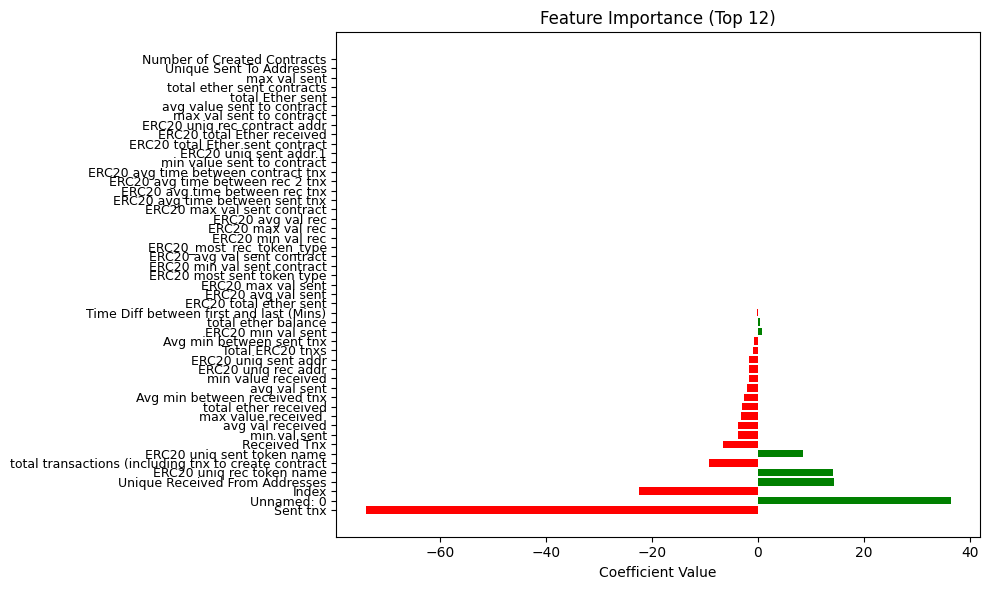


Top 5 Most Important Features:
1. Sent tnx: -74.023722
2. Unnamed: 0: 36.420698
3. Index: -22.366857
4. Unique Received From Addresses: 14.321831
5.  ERC20 uniq rec token name: 14.209996


In [17]:
feat_importances = logreg.coef_[0]
indices = np.argsort(np.abs(feat_importances))[::-1]  # Sort by absolute value, descending

fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Feature Importance (Top 12)")
colors = ['red' if x < 0 else 'green' for x in feat_importances[indices]]
plt.barh(range(len(feat_importances)), feat_importances[indices], align="center", color=colors)
# Prefer computed feature_names (from earlier) to avoid mismatch; fallback to existing 'columns' if needed
names = feature_names if 'feature_names' in globals() else columns
plt.yticks(range(len(feat_importances)), [names[i] for i in indices], fontsize=9)
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()

print("\nTop 5 Most Important Features:")
for i in range(5):
    idx = indices[i]
    print(f"{i+1}. {names[idx]}: {feat_importances[idx]:.6f}")

In [18]:
# Save the trained model
model_path = './logistic_regression_model.pkl'
scaler_path = './scaler.pkl'

with open(model_path, 'wb') as f:
    pickle.dump(logreg, f)

with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

print(f"Model saved to {model_path}")
print(f"Scaler saved to {scaler_path}")

Model saved to ./logistic_regression_model.pkl
Scaler saved to ./scaler.pkl
